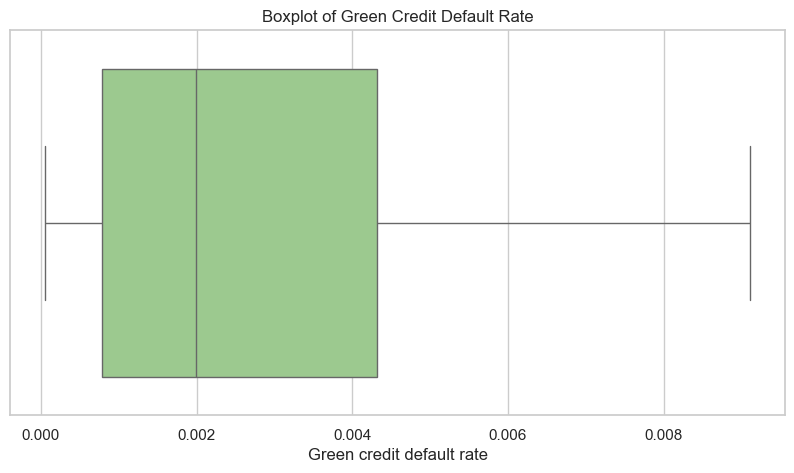

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_excel("GreenLoan_cleaned.xlsx")

# 使用箱线图查看异常值
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Green credit default rate"], color="#96D385")
plt.title("Boxplot of Green Credit Default Rate")
plt.show()

In [83]:
import numpy as np 

# 计算Q1（25%分位数）和Q3（75%分位数）
Q1 = df["Green credit default rate"].quantile(0.25)
Q3 = df["Green credit default rate"].quantile(0.75)

# 计算IQR（四分位距）
IQR = Q3 - Q1

# 计算上下边界
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 识别异常值
outliers = df[(df["Green credit default rate"] < lower_bound) | (df["Green credit default rate"] > upper_bound)]
print(f"Outliers: {len(outliers)}")
print(outliers)

Outliers: 0
Empty DataFrame
Columns: [Code, Year, Industry, Proportion of green credit loans, Proportion of interest expenses on green credit loans, Green credit default rate, Restricted industry for green credit, ESG score, Debt-to-asset ratio, ROA, Interest Expenses to Cash Flow Ratio, Cash to Total Assets, ROE, Current Ratio, Quick Ratio, Operating Cash Flow Ratio, mortgage, ST loan, Value book ratio, Inventory turnover ratio, Log(assets), province, District code, green patent applications, green inventions,  utility model green patent applications, green patents granted, green invention patents authorized]
Index: []

[0 rows x 28 columns]


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=206, reg_alpha=1, reg_lambda=0, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=206, reg_alpha=1, reg_lambda=0, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.01, max_depth=7, n_estimators=206, reg_alpha=1, reg_lambda=0, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=260, reg_alpha=1, reg_lambda=0.01, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=430, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=430, reg_alpha=0.1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END c

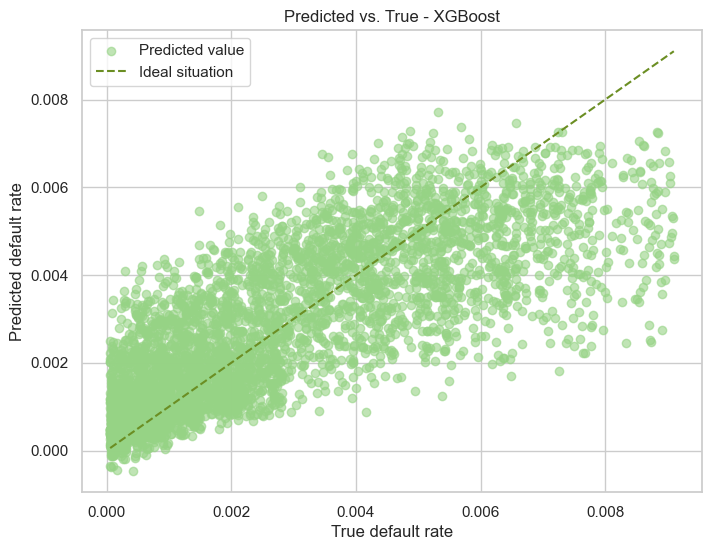

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr, randint

# 1️⃣ 读取数据
file_path = "greenloan_cleaned.xlsx"  # 替换为你的数据文件路径
df = pd.read_excel(file_path)

# 2️⃣ 处理异常值
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

# 3️⃣ 处理类别变量（仅转换 'Industry'）
categorical_cols = ["Industry", "province"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
# 4️⃣ 选择特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])  # 特征
y = df["Green credit default rate"]  # 目标变量

# 5️⃣ 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 数据集拆分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7️⃣ 定义 XGBoost 超参数搜索范围
param_dist = {
    'n_estimators': randint(100, 1000),  # 树的数量
    'max_depth': [3, 5, 7, 10],  # 树的深度
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 学习率
    'subsample': [0.6, 0.8, 1.0],  # 采样比例
    'colsample_bytree': [0.6, 0.8, 1.0],  # 每棵树的特征采样比例
    'gamma': [0, 0.1, 0.2, 0.3],  # 正则化参数
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 正则
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 正则
}

# 8️⃣ 使用 RandomizedSearchCV 进行超参数优化
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, 
                                   n_iter=50, cv=3, scoring="r2", 
                                   n_jobs=-1, verbose=2, random_state=42)

random_search.fit(X_train, y_train)

# 9️⃣ 获取最佳参数
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 🔟 使用最佳参数训练最终 XGBoost 模型
best_xgb_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror", random_state=42)
best_xgb_model.fit(X_train, y_train)

# 1️⃣1️⃣ 预测
y_pred = best_xgb_model.predict(X_test)

# 1️⃣2️⃣ 计算回归指标
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
spearman_corr, _ = spearmanr(y_test, y_pred)

# 1️⃣3️⃣ 打印结果
print(f"R² Score: {r2:.6f}")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Spearman Correlation: {spearman_corr:.6f}")

# 1️⃣4️⃣ 可视化预测值 vs 真实值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="#96D385", label="Predicted value")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="olivedrab", linestyle="--", label="Ideal situation")
plt.xlabel("True default rate")
plt.ylabel("Predicted default rate")
plt.title("Predicted vs. True - XGBoost")
plt.legend()
plt.show()

Repeated Split (XGBoost): 100%|██████████| 500/500 [00:51<00:00,  9.78it/s]


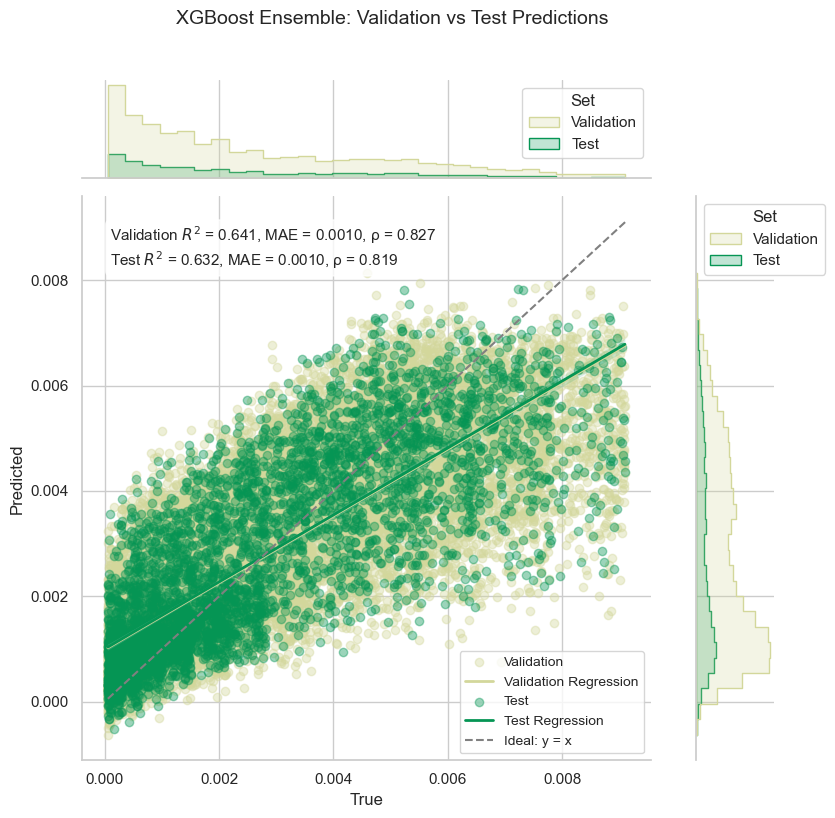

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import spearmanr
from tqdm import tqdm
from xgboost import XGBRegressor

# 1️⃣ 读取数据
df = pd.read_excel("GreenLoan_cleaned.xlsx")

# 2️⃣ 清洗数据
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# 3️⃣ 编码类别变量
categorical_cols = ["Industry", "province"]
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 4️⃣ 特征和目标变量
X = df.drop(columns=["Code", "Year", "Green credit default rate"])
y = df["Green credit default rate"]

# 5️⃣ 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6️⃣ 拆分训练集/测试集
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 7️⃣ 多次训练并记录结果
n_repeats = 500
results = []
y_test_preds = []
y_val_preds = []  # ✅ 保存验证集预测（含索引）

for i in tqdm(range(n_repeats), desc="Repeated Split (XGBoost)"):
    X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=i)

    model = XGBRegressor(random_state=i, verbosity=0)
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_preds.append((y_val.index, y_val_pred))  # ✅ 保存验证集预测

    y_test_pred = model.predict(X_test)
    y_test_preds.append(y_test_pred)

    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        spearman_corr, _ = spearmanr(y_true, y_pred)
        return r2, mse, rmse, mae, spearman_corr

    r2_val, mse_val, rmse_val, mae_val, spearman_val = evaluate(y_val, y_val_pred)
    r2_test, mse_test, rmse_test, mae_test, spearman_test = evaluate(y_test, y_test_pred)

    results.append({
        "run": i,
        "R2_val": r2_val,
        "MAE_val": mae_val,
        "RMSE_val": rmse_val,
        "Spearman_val": spearman_val,
        "R2_test": r2_test,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "Spearman_test": spearman_test
    })

# 8️⃣ 模型集成预测（测试集）
y_test_ensemble_pred = np.mean(y_test_preds, axis=0)

# 9️⃣ 验证集预测平均（按索引）
val_pred_dict = {}
for idx, preds in y_val_preds:
    for i, row_id in enumerate(idx):
        if row_id not in val_pred_dict:
            val_pred_dict[row_id] = []
        val_pred_dict[row_id].append(preds[i])

val_avg_preds = {k: np.mean(v) for k, v in val_pred_dict.items()}

# 生成验证集 DataFrame
df_val = pd.DataFrame({
    "True": y_trainval.loc[val_avg_preds.keys()],
    "Predicted": list(val_avg_preds.values()),
    "Set": "Validation"
})

# 生成测试集 DataFrame
df_test = pd.DataFrame({
    "True": y_test,
    "Predicted": y_test_ensemble_pred,
    "Set": "Test"
})

# 合并验证集和测试集
df_plot = pd.concat([df_val, df_test], ignore_index=True)

# 🔟 计算指标
r2_val = r2_score(df_val["True"], df_val["Predicted"])
r2_test = r2_score(df_test["True"], df_test["Predicted"])
mae_val = mean_absolute_error(df_val["True"], df_val["Predicted"])
mae_test = mean_absolute_error(df_test["True"], df_test["Predicted"])
spearman_val, _ = spearmanr(df_val["True"], df_val["Predicted"])
spearman_test, _ = spearmanr(df_test["True"], df_test["Predicted"])

# 📈 可视化
sns.set(style="whitegrid")
palette = {"Validation": "#D3D79B", "Test": "#059554"}

g = sns.JointGrid(data=df_plot, x="True", y="Predicted", height=8)

# 散点图 + 回归线
for label, color in palette.items():
    subset = df_plot[df_plot["Set"] == label]
    g.ax_joint.scatter(subset["True"], subset["Predicted"], alpha=0.4, color=color, label=label)
    sns.regplot(data=subset, x="True", y="Predicted", ax=g.ax_joint,
                scatter=False, color=color, line_kws={"linewidth": 2}, label=f"{label} Regression")

# 理想线 y = x
min_val = df_plot["True"].min()
max_val = df_plot["True"].max()
g.ax_joint.plot([min_val, max_val], [min_val, max_val], '--', color='gray', label="Ideal: y = x")

# 边缘直方图
sns.histplot(data=df_plot, x="True", hue="Set", ax=g.ax_marg_x,
             bins=30, element="step", common_norm=False, palette=palette)
sns.histplot(data=df_plot, y="Predicted", hue="Set", ax=g.ax_marg_y,
             bins=30, element="step", common_norm=False, palette=palette)

# 添加文本说明
g.ax_joint.text(
    0.05, 0.95,
    f"Validation $R^2$ = {r2_val:.3f}, MAE = {mae_val:.4f}, ρ = {spearman_val:.3f}\n"
    f"Test $R^2$ = {r2_test:.3f}, MAE = {mae_test:.4f}, ρ = {spearman_test:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 图例 & 标题
g.ax_joint.legend(loc="lower right", fontsize=10)
plt.suptitle("XGBoost Ensemble: Validation vs Test Predictions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [53]:
# ✅ 打印验证集指标
print("Validation Set Performance (500次平均):")
print(f"R²        : {r2_val:.6f}")
print(f"RMSE      : {np.sqrt(mean_squared_error(df_val['True'], df_val['Predicted'])):.6f}")
print(f"MAE       : {mae_val:.6f}")
print(f"Spearman  : {spearman_val:.6f}")

# ✅ 打印测试集指标
print("Test Set Performance (集成预测):")
print(f"R²        : {r2_test:.6f}")
print(f"RMSE      : {np.sqrt(mean_squared_error(df_test['True'], df_test['Predicted'])):.6f}")
print(f"MAE       : {mae_test:.6f}")
print(f"Spearman  : {spearman_test:.6f}")

Validation Set Performance (500次平均):
R²        : 0.640962
RMSE      : 0.001362
MAE       : 0.000999
Spearman  : 0.826700
Test Set Performance (集成预测):
R²        : 0.632183
RMSE      : 0.001379
MAE       : 0.001016
Spearman  : 0.818768


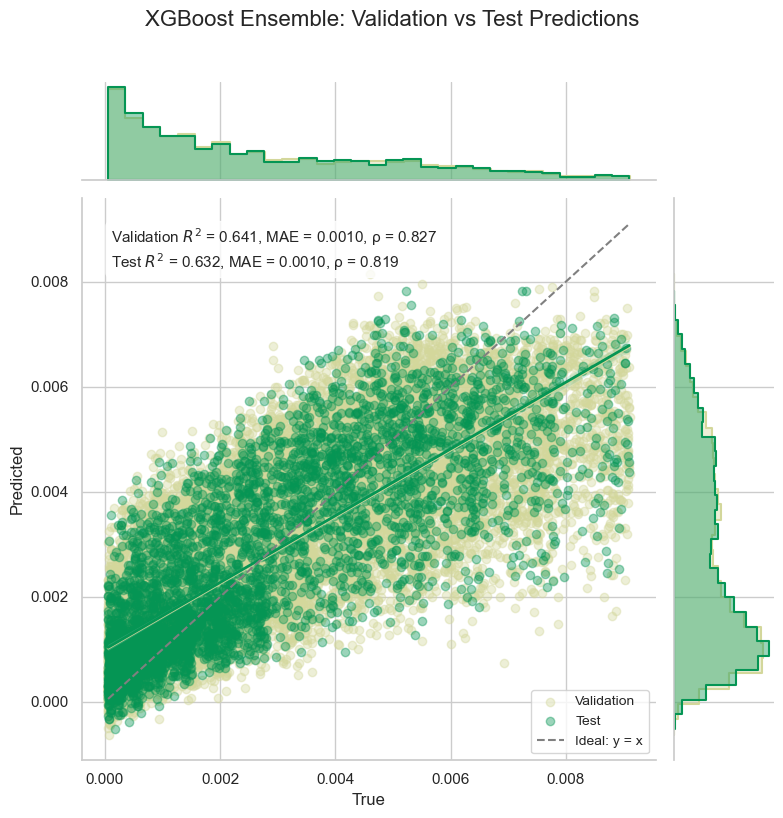

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
palette = {"Validation": "#D3D79B", "Test": "#059554"}

g = sns.JointGrid(data=df_plot, x="True", y="Predicted", height=8)

# 散点图 + 回归线
for label, color in palette.items():
    subset = df_plot[df_plot["Set"] == label]
    g.ax_joint.scatter(subset["True"], subset["Predicted"], alpha=0.4, color=color, label=f"{label}")
    sns.regplot(data=subset, x="True", y="Predicted", ax=g.ax_joint,
                scatter=False, color=color, line_kws={"linewidth": 2})

# 理想线 y = x
min_val = df_plot["True"].min()
max_val = df_plot["True"].max()
g.ax_joint.plot([min_val, max_val], [min_val, max_val], '--', color='gray', label="Ideal: y = x")

# ✅ 分开绘制 histogram，并各自归一化
for label, color in palette.items():
    subset = df_plot[df_plot["Set"] == label]
    sns.histplot(
        subset, x="True", ax=g.ax_marg_x,
        bins=30, stat="density", common_norm=False,
        color=color, alpha=0.4, fill=True,
        element="step", edgecolor=color, linewidth=1.5
    )
    sns.histplot(
        subset, y="Predicted", ax=g.ax_marg_y,
        bins=30, stat="density", common_norm=False,
        color=color, alpha=0.4, fill=True,
        element="step", edgecolor=color, linewidth=1.5
    )

# 添加文本说明
g.ax_joint.text(
    0.05, 0.95,
    f"Validation $R^2$ = {r2_val:.3f}, MAE = {mae_val:.4f}, ρ = {spearman_val:.3f}\n"
    f"Test $R^2$ = {r2_test:.3f}, MAE = {mae_test:.4f}, ρ = {spearman_test:.3f}",
    transform=g.ax_joint.transAxes,
    fontsize=11,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# 图例 & 标题
g.ax_joint.legend(loc="lower right", fontsize=10)
plt.suptitle("XGBoost Ensemble: Validation vs Test Predictions", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

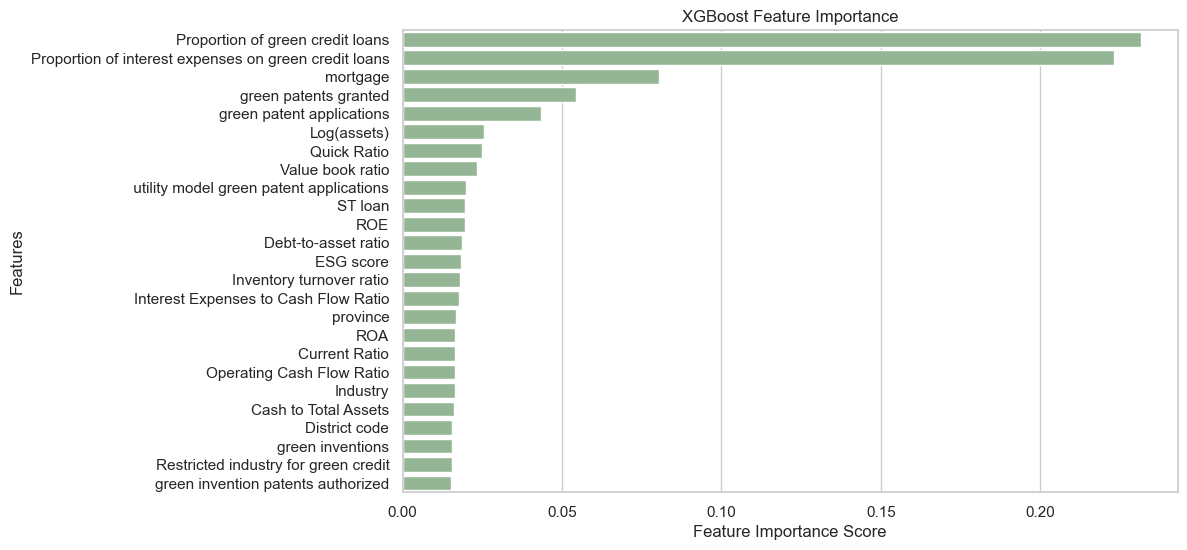

Top 10 Important Features:
                                              Feature  Importance
1                    Proportion of green credit loans    0.231433
2   Proportion of interest expenses on green credi...    0.223153
13                                           mortgage    0.080542
23                              green patents granted    0.054277
20                          green patent applications    0.043421
17                                        Log(assets)    0.025599
11                                        Quick Ratio    0.025063
15                                   Value book ratio    0.023342
22            utility model green patent applications    0.019828
14                                            ST loan    0.019610


In [76]:

# 8️⃣ 提取 & 可视化特征重要性
feature_importance = model.feature_importances_
feature_names = X.columns

# 转换为 DataFrame
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 📊 可视化
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, color="darkseagreen")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.show()

# 9️⃣ 输出最重要的前 10 个特征
print("Top 10 Important Features:")
print(importance_df.head(10))